In [1]:
import os
if not os.path.exists('data'):
    new_directory_path = "..\\..\\"
    os.chdir(new_directory_path)
from src.data.datasets import FreeViewInMemory
import numpy as np
import matplotlib.pyplot as plt


In [2]:
PathDataset = FreeViewInMemory()

In [3]:
durations = []
for i in range(len(PathDataset)):
    durations.append(PathDataset[i][1][2])
durations = np.concat(durations)

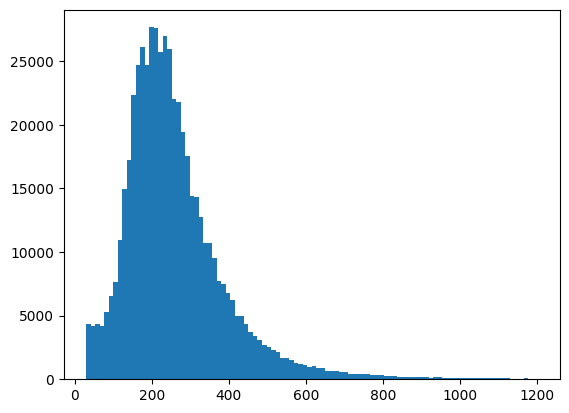

In [4]:
plt.hist(durations, bins=100)
plt.show()


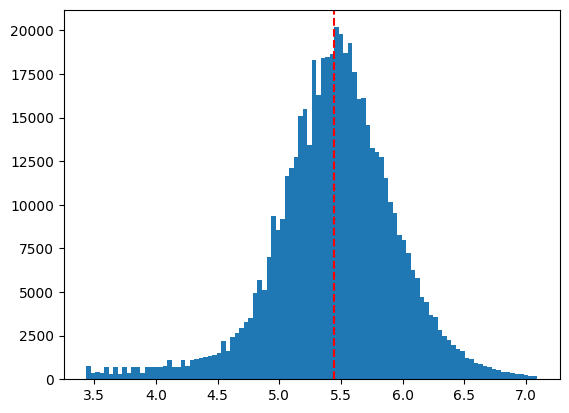

In [5]:
log_durations = np.log1p(durations)
plt.hist(log_durations, bins=100)
# plot mean
plt.axvline(log_durations.mean(), color='red', linestyle='--', label='Mean')
plt.show()

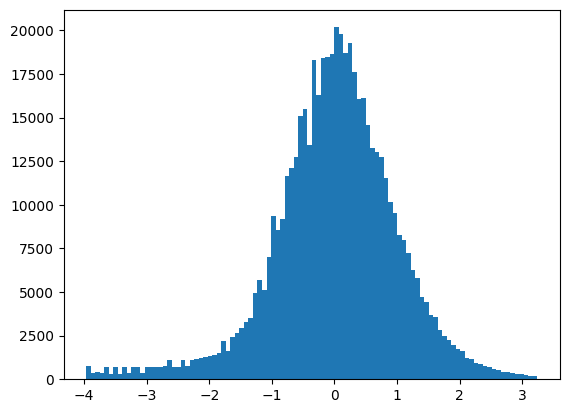

In [6]:
d_mean = log_durations.mean()
d_std = log_durations.std()


z_scores = (log_durations - log_durations.mean()) / log_durations.std()

plt.hist(z_scores, bins=100)
plt.show()


Are x_inv and z_scores_inv (np.tan inversion) numerically equivalent? True


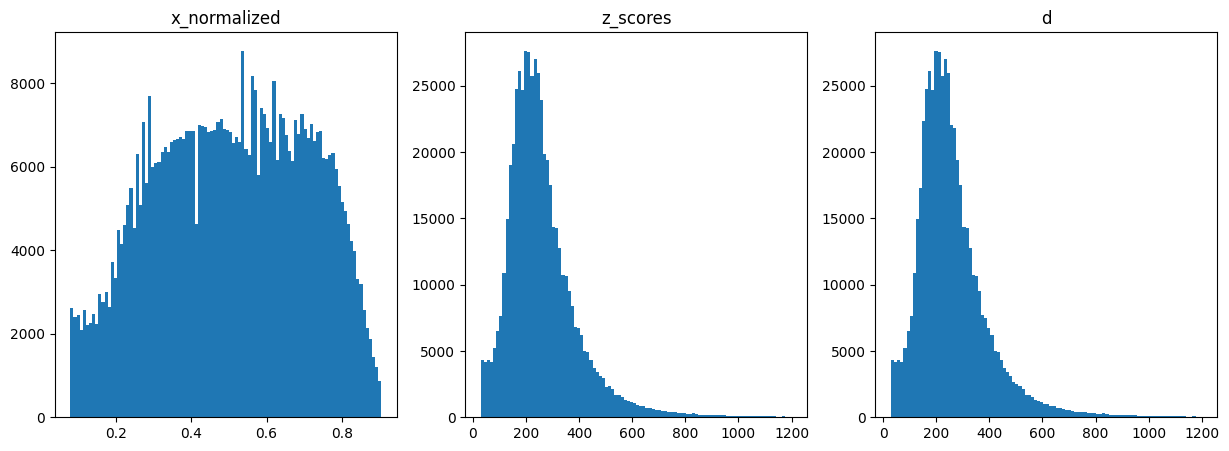

In [19]:
import torch

log_durations = np.log1p(durations)
d_mean = log_durations.mean()
d_std = log_durations.std()


z_scores = (log_durations - log_durations.mean()) / log_durations.std()
x_normalized = (1 / np.pi) * np.arctan(z_scores) + 0.5
#x_inv = np.tan(np.pi*(x_normalized - 0.5))

d = torch.tan(torch.pi*(torch.from_numpy(x_normalized) - 0.5))
recovered_durations = (torch.exp((d*d_std) + d_mean) - 1).numpy()
# Compare x_inv computed manually with the expected result from np.arctan and np.tan inverses

# Compute the expected z_scores back from x_normalized using the numpy inverse of the normalization
# Check equivalence with x_inv (already computed above)
print("Are x_inv and z_scores_inv (np.tan inversion) numerically equivalent?",
      np.allclose(d, z_scores, atol=1e-8))


fig, axis = plt.subplots(1,3, figsize=(15,5))
axis[0].hist(x_normalized, bins=100)
axis[0].set_title('x_normalized')
axis[1].hist(recovered_durations, bins=100)
axis[1].set_title('z_scores')
axis[2].hist(durations, bins=100)
axis[2].set_title('d')
plt.show()


In [8]:
print(log_durations.mean())
print(log_durations.std())

print((z_scores < -1.5).sum()/len(z_scores))
print((z_scores < -2.5).sum()/len(z_scores))
print((z_scores > 1.5).sum()/len(z_scores))
print((z_scores > 2.5).sum()/len(z_scores))

5.44810063342112
0.507648587513406
0.06071945326647799
0.022686529133944252
0.05444220986631965
0.006799588675845626


(512, 1664)


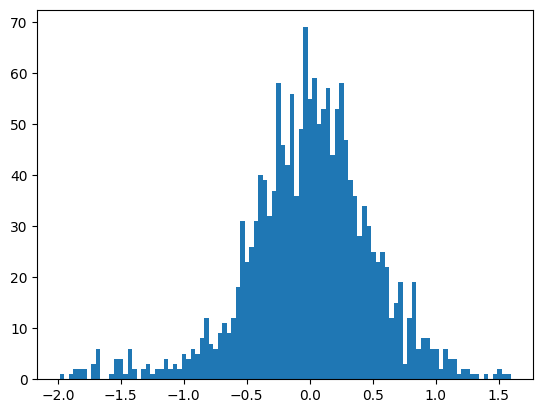

0.11838942307692307
0.038461538461538464
0.004807692307692308
0.0
0.0


In [9]:
temp = np.random.choice(z_scores/2, size=13*128, replace=True)
normal = np.random.standard_normal(512)
test = temp[None,:]*normal[:,None]
print(test.shape)
to_plot = temp.flatten()
plt.hist(to_plot, bins=100)
plt.show()
per1 = np.sum((test > 1).reshape(test.shape), axis = 0)/test.shape[0]
per2 = np.sum((test < -1).reshape(test.shape), axis = 0)/test.shape[0]
per = per1 + per2
print((per > 0.2).sum()/len(per))
print((per > 0.4).sum()/len(per))
print((per > 0.6).sum()/len(per))
print((per > 0.7).sum()/len(per))
print((per > 0.8).sum()/len(per))

In [10]:
import numpy as np
from scipy.stats import normaltest

statistic, p_value = normaltest(log_durations)

alpha = 0.05

print(f"Test Statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Significance Level (alpha): {alpha}")

if p_value > alpha:
    print("\nConclusion: Fail to reject the Null Hypothesis (H0). The data appears to be normally distributed.")
else:
    print("\nConclusion: Reject the Null Hypothesis (H0). The data does not appear to be normally distributed.")

Test Statistic: 40793.2029
P-value: 0.0000
Significance Level (alpha): 0.05

Conclusion: Reject the Null Hypothesis (H0). The data does not appear to be normally distributed.


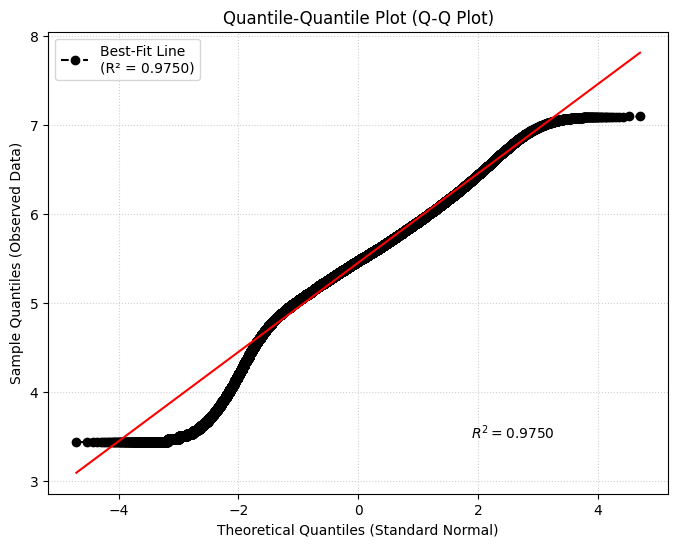

Squared Correlation Coefficient (R²): 0.9750


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import probplot # We use the core SciPy function here

# --- 1. Define or Generate the Data ---


# --- 2. Generate the Q-Q Plot using scipy.stats.probplot ---
fig, ax = plt.subplots(figsize=(8, 6))

# Correct Unpacking: probplot returns (osm, (slope, intercept, r))
(osm, (slope, intercept, r)) = probplot(
    log_durations, 
    dist="norm", 
    plot=ax,
    rvalue=True # Calculate and include the correlation coefficient (r)
) 

# --- 3. Customization (No change needed here) ---
ax.set_title("Quantile-Quantile Plot (Q-Q Plot)")
ax.set_xlabel("Theoretical Quantiles (Standard Normal)")
ax.set_ylabel("Sample Quantiles (Observed Data)")

# The rest of your customization code will work as intended...
line = ax.get_lines()[0]
line.set_color('black')
line.set_linestyle('--')
line.set_label(f'Best-Fit Line\n(R² = {r**2:.4f})')

ax.grid(True, linestyle=':', alpha=0.6)
ax.legend()
plt.show()

print(f"Squared Correlation Coefficient (R²): {r**2:.4f}")

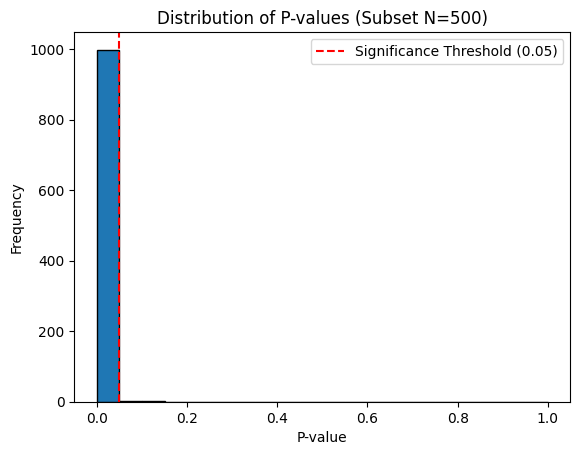

Mean P-value: 0.0003
Percentage of subsets passing normality (>0.05): 0.2%


In [12]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Assume 'durations_log' is your transformed data (500k samples)
subset_size = 500  # A reasonable size for normality testing
num_trials = 1000
p_values = []

for _ in range(num_trials):
    # Take a random subset
    subset = np.random.choice(log_durations, size=subset_size, replace=False)
    stat, p = stats.normaltest(subset)
    p_values.append(p)

# Plotting the result
plt.hist(p_values, bins=20, range=(0, 1), edgecolor='black')
plt.axvline(x=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.title(f"Distribution of P-values (Subset N={subset_size})")
plt.xlabel("P-value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(f"Mean P-value: {np.mean(p_values):.4f}")
print(f"Percentage of subsets passing normality (>0.05): {np.mean(np.array(p_values) > 0.05)*100:.1f}%")

In [13]:
error = np.exp(0.2587*2*0.5076 + 5.4481) - 1
print(error)

301.09219130150933


In [14]:
print(np.exp(0.2587))
print(np.exp(0.00005))
print(np.exp(5.4481))

1.2952451729842913
1.0000500012500209
232.31634525497196
